In [1]:
import pandas as pd
import numpy as np

from ydata_profiling import ProfileReport

from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

from rdkit.Chem import AllChem
from lazypredict.Supervised import LazyClassifier
from numpy.random import seed
from numpy.random import randn
from scipy.stats import mannwhitneyu
import re

import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

import lazypredict
from lazypredict.Supervised import LazyClassifier

from lightgbm import LGBMClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torch

import scikitplot as skplt
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

## Chembl

In [2]:
effective_raw_data_clean = pd.read_csv('./data/effective_raw_data_clean.csv')

In [3]:
effective_raw_data_clean['Standard Value'] = effective_raw_data_clean['Standard Value'].apply(lambda x: -np.log10(x * 10 ** (-9)))
effective_raw_data_clean

,Molecule ChEMBL ID,Smiles,Standard Value,AlogP,Molecular Weight
0,CHEMBL276690,O=P(O)(O)C(Cc1cccc2c1OCO2)N[C@@H](Cc1ccc(-c2cc...,9.15,3.22,493.46
1,CHEMBL431691,CC(O)C(NC(=O)C(Cc1ccccc1)CP(=O)(O)[C@H](Cc1ccc...,5.00,3.56,582.59
2,CHEMBL212001,CCc1nnc(NC(=O)C2(CCC(=O)O)CCCC2)s1,6.63,2.46,297.38
3,CHEMBL27842,NC(=O)CC(NC(=O)C(Cc1ccccc1)CP(=O)(O)[C@H](Cc1c...,5.00,3.06,595.59
4,CHEMBL273898,CC(C)CC(NC(=O)C(CS)C(C)c1ccccc1)C(=O)O,8.46,2.95,323.46
...,...,...,...,...,...
463,CHEMBL3221954,COC(=O)[C@H](CC(=O)N[C@@H](CO)C(=O)O)CC(C)C,4.10,-0.23,275.30
464,CHEMBL4434901,O=C(O)CCC(=O)N[C@@H](CC(=O)O)Cc1ccc(-c2ccccc2F...,7.62,2.86,373.38
465,CHEMBL4550194,CC(=O)Nc1cccc(-c2ccc(C[C@H](CC(=O)O)NC(=O)CCC(...,5.31,2.68,412.44
466,CHEMBL50582,C[C@H](NC(=O)[C@@H](CS)Cc1ccccc1)C(=O)N1c2cccc...,8.59,2.32,412.51


In [4]:
bioactivity_threshold = []
for i in effective_raw_data_clean['Standard Value']:
  if float(i) >= 6.0:
    bioactivity_threshold.append('active')  # inactive == 0
  elif float(i) < 6.0:
    bioactivity_threshold.append('inactive')    # active == 1
  
  
effective_raw_data_clean['class'] = bioactivity_threshold
effective_raw_data_clean_class = effective_raw_data_clean
effective_raw_data_clean_class

,Molecule ChEMBL ID,Smiles,Standard Value,AlogP,Molecular Weight,class
0,CHEMBL276690,O=P(O)(O)C(Cc1cccc2c1OCO2)N[C@@H](Cc1ccc(-c2cc...,9.15,3.22,493.46,active
1,CHEMBL431691,CC(O)C(NC(=O)C(Cc1ccccc1)CP(=O)(O)[C@H](Cc1ccc...,5.00,3.56,582.59,inactive
2,CHEMBL212001,CCc1nnc(NC(=O)C2(CCC(=O)O)CCCC2)s1,6.63,2.46,297.38,active
3,CHEMBL27842,NC(=O)CC(NC(=O)C(Cc1ccccc1)CP(=O)(O)[C@H](Cc1c...,5.00,3.06,595.59,inactive
4,CHEMBL273898,CC(C)CC(NC(=O)C(CS)C(C)c1ccccc1)C(=O)O,8.46,2.95,323.46,active
...,...,...,...,...,...,...
463,CHEMBL3221954,COC(=O)[C@H](CC(=O)N[C@@H](CO)C(=O)O)CC(C)C,4.10,-0.23,275.30,inactive
464,CHEMBL4434901,O=C(O)CCC(=O)N[C@@H](CC(=O)O)Cc1ccc(-c2ccccc2F...,7.62,2.86,373.38,active
465,CHEMBL4550194,CC(=O)Nc1cccc(-c2ccc(C[C@H](CC(=O)O)NC(=O)CCC(...,5.31,2.68,412.44,inactive
466,CHEMBL50582,C[C@H](NC(=O)[C@@H](CS)Cc1ccccc1)C(=O)N1c2cccc...,8.59,2.32,412.51,active


In [5]:
# Inspired by: https://codeocean.com/explore/capsules?query=tag:data-curation

def lipinski(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        mol = Chem.MolFromSmiles(elem) 
        moldata.append(mol)
       
    baseData= np.arange(1,1)
    i=0  
    for mol in moldata:        
       
        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)
           
        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])   
    
        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1      
    
    columnNames=["MW","LogP","NumHDonors","NumHAcceptors"]   
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)
    
    return descriptors

In [6]:
df_lipinski = lipinski(effective_raw_data_clean_class.Smiles)
df_lipinski

,MW,LogP,NumHDonors,NumHAcceptors
0,493.46,3.22,4.00,7.00
1,582.59,3.56,5.00,6.00
2,297.38,2.46,2.00,5.00
3,595.59,3.06,5.00,6.00
4,323.46,2.95,3.00,3.00
...,...,...,...,...
463,275.30,-0.23,3.00,5.00
464,373.38,2.86,3.00,3.00
465,412.44,2.68,4.00,4.00
466,412.51,2.32,3.00,4.00


In [7]:
effective_raw_data_lipinski = pd.concat([effective_raw_data_clean_class, df_lipinski], axis= 1)
effective_raw_data_lipinski

,Molecule ChEMBL ID,Smiles,Standard Value,AlogP,Molecular Weight,class,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL276690,O=P(O)(O)C(Cc1cccc2c1OCO2)N[C@@H](Cc1ccc(-c2cc...,9.15,3.22,493.46,active,493.46,3.22,4.00,7.00
1,CHEMBL431691,CC(O)C(NC(=O)C(Cc1ccccc1)CP(=O)(O)[C@H](Cc1ccc...,5.00,3.56,582.59,inactive,582.59,3.56,5.00,6.00
2,CHEMBL212001,CCc1nnc(NC(=O)C2(CCC(=O)O)CCCC2)s1,6.63,2.46,297.38,active,297.38,2.46,2.00,5.00
3,CHEMBL27842,NC(=O)CC(NC(=O)C(Cc1ccccc1)CP(=O)(O)[C@H](Cc1c...,5.00,3.06,595.59,inactive,595.59,3.06,5.00,6.00
4,CHEMBL273898,CC(C)CC(NC(=O)C(CS)C(C)c1ccccc1)C(=O)O,8.46,2.95,323.46,active,323.46,2.95,3.00,3.00
...,...,...,...,...,...,...,...,...,...,...
463,CHEMBL3221954,COC(=O)[C@H](CC(=O)N[C@@H](CO)C(=O)O)CC(C)C,4.10,-0.23,275.30,inactive,275.30,-0.23,3.00,5.00
464,CHEMBL4434901,O=C(O)CCC(=O)N[C@@H](CC(=O)O)Cc1ccc(-c2ccccc2F...,7.62,2.86,373.38,active,373.38,2.86,3.00,3.00
465,CHEMBL4550194,CC(=O)Nc1cccc(-c2ccc(C[C@H](CC(=O)O)NC(=O)CCC(...,5.31,2.68,412.44,inactive,412.44,2.68,4.00,4.00
466,CHEMBL50582,C[C@H](NC(=O)[C@@H](CS)Cc1ccccc1)C(=O)N1c2cccc...,8.59,2.32,412.51,active,412.51,2.32,3.00,4.00


In [8]:
def mannwhitney(descriptor, verbose=False):
  # https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/

# seed the random number generator
  seed(1)

# actives and inactives
  selection = [descriptor, 'class']
  df = effective_raw_data_lipinski[selection]
  active = df[df['class'] == 'active']
  active = active[descriptor]

  selection = [descriptor, 'class']
  df = effective_raw_data_lipinski[selection]
  inactive = df[df['class'] == 'inactive']
  inactive = inactive[descriptor]

# compare samples
  stat, p = mannwhitneyu(active, inactive)
  #print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
  alpha = 0.05
  if p > alpha:
    interpretation = 'Same distribution (fail to reject H0)'
  else:
    interpretation = 'Different distribution (reject H0)'
  
  results = pd.DataFrame({'Descriptor':descriptor,
                          'Statistics':stat,
                          'p':p,
                          'alpha':alpha,
                          'Interpretation':interpretation}, index=[0])
  filename = 'mannwhitneyu_' + descriptor + '.csv'
  results.to_csv(filename)

  return results

In [9]:
mannwhitney('Standard Value')

,Descriptor,Statistics,p,alpha,Interpretation
0,Standard Value,48515.00,0.00,0.05,Different distribution (reject H0)


In [10]:
mannwhitney('MW')

,Descriptor,Statistics,p,alpha,Interpretation
0,MW,18499.50,0.00,0.05,Different distribution (reject H0)


In [11]:
mannwhitney('LogP')

,Descriptor,Statistics,p,alpha,Interpretation
0,LogP,31360.50,0.00,0.05,Different distribution (reject H0)


In [12]:
mannwhitney('NumHDonors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHDonors,18035.50,0.00,0.05,Different distribution (reject H0)


In [13]:
mannwhitney('NumHAcceptors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHAcceptors,18612.00,0.00,0.05,Different distribution (reject H0)


In [14]:
effective_raw_data_lipinski.to_csv('./data/effective_raw_data_lipinski.csv', index = None)

In [15]:
def smiles_dataset(dataset_df = None, smiles_loc = 'Smiles', fp_radius = 3, fp_bits = 1024):

    '''
    Use this function to generate the dataframe of fingerprint
    dataset_df: the input dataset should be a dataframe
    smiles_loc: the column name that consists of SMILES strings
    fp_radius = the radius of Morgan fingerprint
    fp_bits = the number of fingerprint bits of Morgan fingerprint
    '''

    smiles = dataset_df[smiles_loc]
    smiles_list = np.array(smiles).tolist()

    mols = [Chem.MolFromSmiles(smile) for smile in smiles_list]

    mols = [Chem.AddHs(smile) for smile in mols]  # Note that add Hs would change the fingerprint albeit the same molecule

    morgans = [AllChem.GetMorganFingerprintAsBitVect(mol, radius = fp_radius,
                nBits= fp_bits, useChirality = True) for mol in mols]

    morgan_bits =  [morgan.ToBitString() for morgan in morgans]

    pattern = re.compile('.{1}')  # find every single digit
    morgan_bits = [','.join(pattern.findall(morgan)) for morgan in morgan_bits]

    fp_list = []
    for bit in morgan_bits:
        single_fp = bit.split(',')   # split the string by commas
        single_fp = [float(fp) for fp in single_fp] # transfer string to float32
        fp_list.append(single_fp)

    fp_df = pd.DataFrame(np.array(fp_list))
    fp_df.columns = fp_df.columns.astype(str)

    # rename the columns
    for i in range(fp_df.columns.shape[0]):
        fp_df.rename(columns = {fp_df.columns[i]:fp_df.columns[i] + "pIC50"}, inplace = True)

    return fp_df

In [16]:
fingerprints = smiles_dataset(dataset_df = effective_raw_data_lipinski, smiles_loc = 'Smiles')
fingerprints

,0pIC50,1pIC50,2pIC50,3pIC50,4pIC50,5pIC50,6pIC50,7pIC50,8pIC50,9pIC50,...,1014pIC50,1015pIC50,1016pIC50,1017pIC50,1018pIC50,1019pIC50,1020pIC50,1021pIC50,1022pIC50,1023pIC50
0,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
464,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
465,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
466,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,1.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00


In [17]:
effective_raw_data_lipinski = effective_raw_data_lipinski.rename(columns={'Standard Value':'pIC50'})
x_complete_chembl = pd.concat([fingerprints, effective_raw_data_lipinski[['LogP', 'MW']]], axis = 1)
x_complete_chembl

,0pIC50,1pIC50,2pIC50,3pIC50,4pIC50,5pIC50,6pIC50,7pIC50,8pIC50,9pIC50,...,1016pIC50,1017pIC50,1018pIC50,1019pIC50,1020pIC50,1021pIC50,1022pIC50,1023pIC50,LogP,MW
0,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3.22,493.46
1,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3.56,582.59
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.46,297.38
3,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3.06,595.59
4,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.95,323.46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.23,275.30
464,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.86,373.38
465,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.68,412.44
466,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,2.32,412.51


In [18]:
y_complete_chembl = effective_raw_data_lipinski['class']
y_complete_chembl

0        active
1      inactive
2        active
3      inactive
4        active
         ...   
463    inactive
464      active
465    inactive
466      active
467      active
Name: class, Length: 468, dtype: object

## BindingDB

In [19]:
BindingDB = pd.read_csv('./Data_BindingDB/effective_raw_data_clean_for_calculation.csv')
BindingDB

,BindingDB MonomerID,Ligand SMILES,IC50 (nM)
0,50035247,CC(C)C(C(=O)NO)C(=O)NC(Cc1c[nH]c2ccccc12)C(O)=O,10.52
1,155343,C[C@H](C[C@@H](Cc1ccc(cc1)-c1cccc(Cl)c1)NC(=O)...,10.52
2,50035246,CC(C)CC(C(=O)NO)C(=O)NC(Cc1c[nH]c2ccccc12)C(O)=O,10.52
3,153121,C[C@@H](C[C@@H](Cc1ccc(cc1)-c1cccc(Cl)c1)NC(=O...,10.40
4,309469,C[C@H](C[C@@H](Cc1ccc(cc1)-c1cccc(Cl)c1)NC(=O)...,10.40
...,...,...,...
879,50027516,CC(C)C[C@H](NC(=O)[C@@H](N)Cc1ccccc1)C(O)=O,3.15
880,50085456,CC(C)C[C@H](NC(=O)C(CN(O)C(N)=O)Cc1ccccc1)C(=O...,3.15
881,21642,C[C@H](CS)C(=O)N1CCC[C@H]1C(O)=O,3.08
882,50130715,OC(=O)CCCN=CP(O)(O)CCc1ccccc1,2.70


In [20]:
df_lipinski_DB = lipinski(BindingDB['Ligand SMILES'])
df_lipinski_DB

,MW,LogP,NumHDonors,NumHAcceptors
0,347.37,1.06,5.00,4.00
1,455.90,3.88,4.00,4.00
2,361.40,1.45,5.00,4.00
3,428.87,4.15,3.00,5.00
4,430.89,4.12,5.00,4.00
...,...,...,...,...
879,278.35,1.17,3.00,3.00
880,498.58,1.96,5.00,5.00
881,217.29,0.63,2.00,3.00
882,285.28,1.69,3.00,4.00


In [21]:
complete_DB = pd.concat([BindingDB, df_lipinski_DB], axis=1)
complete_DB

,BindingDB MonomerID,Ligand SMILES,IC50 (nM),MW,LogP,NumHDonors,NumHAcceptors
0,50035247,CC(C)C(C(=O)NO)C(=O)NC(Cc1c[nH]c2ccccc12)C(O)=O,10.52,347.37,1.06,5.00,4.00
1,155343,C[C@H](C[C@@H](Cc1ccc(cc1)-c1cccc(Cl)c1)NC(=O)...,10.52,455.90,3.88,4.00,4.00
2,50035246,CC(C)CC(C(=O)NO)C(=O)NC(Cc1c[nH]c2ccccc12)C(O)=O,10.52,361.40,1.45,5.00,4.00
3,153121,C[C@@H](C[C@@H](Cc1ccc(cc1)-c1cccc(Cl)c1)NC(=O...,10.40,428.87,4.15,3.00,5.00
4,309469,C[C@H](C[C@@H](Cc1ccc(cc1)-c1cccc(Cl)c1)NC(=O)...,10.40,430.89,4.12,5.00,4.00
...,...,...,...,...,...,...,...
879,50027516,CC(C)C[C@H](NC(=O)[C@@H](N)Cc1ccccc1)C(O)=O,3.15,278.35,1.17,3.00,3.00
880,50085456,CC(C)C[C@H](NC(=O)C(CN(O)C(N)=O)Cc1ccccc1)C(=O...,3.15,498.58,1.96,5.00,5.00
881,21642,C[C@H](CS)C(=O)N1CCC[C@H]1C(O)=O,3.08,217.29,0.63,2.00,3.00
882,50130715,OC(=O)CCCN=CP(O)(O)CCc1ccccc1,2.70,285.28,1.69,3.00,4.00


In [22]:
bioactivity_threshold_DB = []
for i in complete_DB['IC50 (nM)']:
  if float(i) >= 6.0:
    bioactivity_threshold_DB.append('active')  # inactive == 0
  elif float(i) < 6.0:
    bioactivity_threshold_DB.append('inactive')    # active == 1
  
  
complete_DB['class'] = bioactivity_threshold_DB
complete_DB_class = complete_DB
complete_DB_class

,BindingDB MonomerID,Ligand SMILES,IC50 (nM),MW,LogP,NumHDonors,NumHAcceptors,class
0,50035247,CC(C)C(C(=O)NO)C(=O)NC(Cc1c[nH]c2ccccc12)C(O)=O,10.52,347.37,1.06,5.00,4.00,active
1,155343,C[C@H](C[C@@H](Cc1ccc(cc1)-c1cccc(Cl)c1)NC(=O)...,10.52,455.90,3.88,4.00,4.00,active
2,50035246,CC(C)CC(C(=O)NO)C(=O)NC(Cc1c[nH]c2ccccc12)C(O)=O,10.52,361.40,1.45,5.00,4.00,active
3,153121,C[C@@H](C[C@@H](Cc1ccc(cc1)-c1cccc(Cl)c1)NC(=O...,10.40,428.87,4.15,3.00,5.00,active
4,309469,C[C@H](C[C@@H](Cc1ccc(cc1)-c1cccc(Cl)c1)NC(=O)...,10.40,430.89,4.12,5.00,4.00,active
...,...,...,...,...,...,...,...,...
879,50027516,CC(C)C[C@H](NC(=O)[C@@H](N)Cc1ccccc1)C(O)=O,3.15,278.35,1.17,3.00,3.00,inactive
880,50085456,CC(C)C[C@H](NC(=O)C(CN(O)C(N)=O)Cc1ccccc1)C(=O...,3.15,498.58,1.96,5.00,5.00,inactive
881,21642,C[C@H](CS)C(=O)N1CCC[C@H]1C(O)=O,3.08,217.29,0.63,2.00,3.00,inactive
882,50130715,OC(=O)CCCN=CP(O)(O)CCc1ccccc1,2.70,285.28,1.69,3.00,4.00,inactive


In [23]:
def mannwhitney(descriptor, verbose=False):
  # https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/

# seed the random number generator
  seed(1)

# actives and inactives
  selection = [descriptor, 'class']
  df = complete_DB_class[selection]
  active = df[df['class'] == 'active']
  active = active[descriptor]

  selection = [descriptor, 'class']
  df = complete_DB_class[selection]
  inactive = df[df['class'] == 'inactive']
  inactive = inactive[descriptor]

# compare samples
  stat, p = mannwhitneyu(active, inactive)
  #print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
  alpha = 0.05
  if p > alpha:
    interpretation = 'Same distribution (fail to reject H0)'
  else:
    interpretation = 'Different distribution (reject H0)'
  
  results = pd.DataFrame({'Descriptor':descriptor,
                          'Statistics':stat,
                          'p':p,
                          'alpha':alpha,
                          'Interpretation':interpretation}, index=[0])
  filename = 'mannwhitneyu_' + descriptor + '.csv'
  results.to_csv(filename)

  return results

In [24]:
mannwhitney('IC50 (nM)')

,Descriptor,Statistics,p,alpha,Interpretation
0,IC50 (nM),101115.00,0.00,0.05,Different distribution (reject H0)


In [25]:
mannwhitney('MW')

,Descriptor,Statistics,p,alpha,Interpretation
0,MW,40322.00,0.00,0.05,Different distribution (reject H0)


In [26]:
mannwhitney('LogP')

,Descriptor,Statistics,p,alpha,Interpretation
0,LogP,57643.50,0.01,0.05,Different distribution (reject H0)


In [27]:
mannwhitney('NumHDonors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHDonors,39537.50,0.00,0.05,Different distribution (reject H0)


In [28]:
mannwhitney('NumHAcceptors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHAcceptors,45159.00,0.04,0.05,Different distribution (reject H0)


In [29]:
fingerprints_DB = smiles_dataset(dataset_df = complete_DB_class, smiles_loc = 'Ligand SMILES')
fingerprints_DB

,0pIC50,1pIC50,2pIC50,3pIC50,4pIC50,5pIC50,6pIC50,7pIC50,8pIC50,9pIC50,...,1014pIC50,1015pIC50,1016pIC50,1017pIC50,1018pIC50,1019pIC50,1020pIC50,1021pIC50,1022pIC50,1023pIC50
0,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00
4,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
879,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
880,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
881,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00
882,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [30]:
complete_DB_class = complete_DB_class.rename(columns={'IC50 (nM)':'pIC50'})
x_complete_DB = pd.concat([fingerprints_DB, complete_DB_class[['LogP', 'MW']]], axis = 1)
x_complete_DB

,0pIC50,1pIC50,2pIC50,3pIC50,4pIC50,5pIC50,6pIC50,7pIC50,8pIC50,9pIC50,...,1016pIC50,1017pIC50,1018pIC50,1019pIC50,1020pIC50,1021pIC50,1022pIC50,1023pIC50,LogP,MW
0,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.06,347.37
1,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,3.88,455.90
2,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.45,361.40
3,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,4.15,428.87
4,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,4.12,430.89
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
879,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.17,278.35
880,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.96,498.58
881,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.63,217.29
882,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.69,285.28


In [31]:
final_x = pd.concat([x_complete_chembl, x_complete_DB], axis = 0)
final_x = final_x.reset_index(drop=True)
final_x

,0pIC50,1pIC50,2pIC50,3pIC50,4pIC50,5pIC50,6pIC50,7pIC50,8pIC50,9pIC50,...,1016pIC50,1017pIC50,1018pIC50,1019pIC50,1020pIC50,1021pIC50,1022pIC50,1023pIC50,LogP,MW
0,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3.22,493.46
1,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3.56,582.59
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.46,297.38
3,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3.06,595.59
4,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.95,323.46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1347,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.17,278.35
1348,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.96,498.58
1349,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.63,217.29
1350,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.69,285.28


In [32]:
# final_x.to_csv('./final_x_classification.csv', index=None)

In [33]:
final_y = pd.concat([effective_raw_data_lipinski['class'], complete_DB_class['class']], axis=0)
final_y = final_y.reset_index(drop=True)
final_y

0         active
1       inactive
2         active
3       inactive
4         active
          ...   
1347    inactive
1348    inactive
1349    inactive
1350    inactive
1351    inactive
Name: class, Length: 1352, dtype: object

In [34]:
# final_y.to_csv('./final_y_classification.csv', index=None)

In [35]:
x_train_class_final, x_test_class_final, y_train_class_final, y_test_class_final = train_test_split(final_x, final_y, test_size=0.2)

In [36]:
x_train_class_final.shape, x_test_class_final.shape

((1081, 1026), (271, 1026))

In [37]:
y_train_class_final.shape, y_test_class_final.shape

((1081,), (271,))

In [38]:
clf = LazyClassifier(verbose = 0, ignore_warnings = True, custom_metric = None, random_state = 64)
models_train, predictions_test = clf.fit(x_train_class_final, x_test_class_final, y_train_class_final, y_test_class_final)

100%|██████████| 29/29 [00:13<00:00,  2.22it/s]

[LightGBM] [Info] Number of positive: 236, number of negative: 845
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004139 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2701
[LightGBM] [Info] Number of data points in the train set: 1081, number of used features: 733
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.218316 -> initscore=-1.275505
[LightGBM] [Info] Start training from score -1.275505
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [39]:
models_train

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LogisticRegression,0.98,0.97,None,0.98,0.20
LinearSVC,0.97,0.97,None,0.97,1.07
PassiveAggressiveClassifier,0.96,0.96,None,0.96,0.14
RidgeClassifierCV,0.96,0.96,None,0.96,0.35
Perceptron,0.95,0.96,None,0.95,0.10
DecisionTreeClassifier,0.96,0.95,None,0.96,0.16
LGBMClassifier,0.97,0.95,None,0.97,0.25
ExtraTreeClassifier,0.95,0.94,None,0.95,0.09
ExtraTreesClassifier,0.96,0.93,None,0.96,0.62


In [40]:
predictions_test

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LogisticRegression,0.98,0.97,None,0.98,0.20
LinearSVC,0.97,0.97,None,0.97,1.07
PassiveAggressiveClassifier,0.96,0.96,None,0.96,0.14
RidgeClassifierCV,0.96,0.96,None,0.96,0.35
Perceptron,0.95,0.96,None,0.95,0.10
DecisionTreeClassifier,0.96,0.95,None,0.96,0.16
LGBMClassifier,0.97,0.95,None,0.97,0.25
ExtraTreeClassifier,0.95,0.94,None,0.95,0.09
ExtraTreesClassifier,0.96,0.93,None,0.96,0.62


In [41]:
LogisticRegression = LogisticRegression(max_iter = 1000, random_state = 64, class_weight = {'active':0.7,'inactive':0.3})
LogisticRegression.fit(x_train_class_final, y_train_class_final)

# LGBMClassifier = LGBMClassifier(random_state=64)
# LGBMClassifier.fit(x_train_class_final, y_train_class_final)

LogisticRegression(class_weight={'active': 0.7, 'inactive': 0.3}, max_iter=1000,
                   random_state=64)

In [42]:
y_pred = LogisticRegression.predict(x_test_class_final)
y_pred

array(['active', 'active', 'active', 'active', 'active', 'active',
       'active', 'active', 'active', 'active', 'active', 'active',
       'active', 'active', 'active', 'inactive', 'active', 'active',
       'active', 'active', 'active', 'active', 'active', 'inactive',
       'inactive', 'active', 'active', 'active', 'active', 'active',
       'inactive', 'active', 'active', 'active', 'active', 'active',
       'active', 'active', 'active', 'active', 'active', 'active',
       'active', 'active', 'inactive', 'active', 'active', 'active',
       'active', 'active', 'active', 'active', 'active', 'active',
       'active', 'active', 'inactive', 'active', 'active', 'active',
       'active', 'active', 'active', 'active', 'active', 'active',
       'inactive', 'inactive', 'inactive', 'active', 'active', 'active',
       'active', 'active', 'active', 'active', 'active', 'active',
       'active', 'active', 'active', 'active', 'active', 'active',
       'active', 'active', 'active', 'active

In [43]:
accuracy_score(y_test_class_final, y_pred)

0.9520295202952029

In [44]:
precision_score(y_test_class_final, y_pred, pos_label='active')

0.9513274336283186

In [45]:
recall_score(y_test_class_final, y_pred, pos_label='active')

0.9907834101382489

In [46]:
f1_score(y_test_class_final, y_pred, pos_label='active')

0.9706546275395034

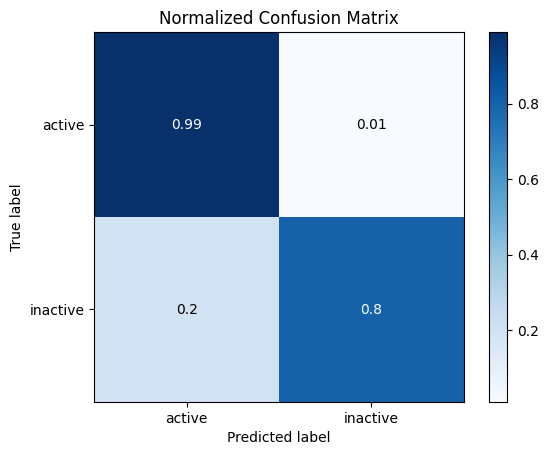

In [47]:
skplt.metrics.plot_confusion_matrix(y_test_class_final, y_pred, normalize=True)
plt.show()

In [48]:
# torch.save(LogisticRegression, './model/LogisticRegression.pth')